# Benchmarking classification time-complexity of SPORF on sklearn `bench_tree.py`

The purpose of the notebook is to benchmark time-complexity of S-RerF on one of the sklearn benchmarking scripts

## Environment
- Python 3.8
- [Sklearn-Adam's dev branch](https://github.com/neurodata/scikit-learn/tree/obliquetrees)

## Import packages

In [1]:
from sklearn.tree import ObliqueDecisionTreeClassifier
from sklearn.ensemble._forest import ObliqueRandomForestClassifier
import pickle
from datetime import datetime
import os

import numpy as np
import matplotlib.pyplot as plt
import gc
from datetime import datetime

# to store the results
scikit_classifier_results = []

mu_second = 0.0 + 10 ** 6  # number of microseconds in a second

In [2]:
today = str(datetime.now().date())
today

'2021-12-21'

## SPORF initialization

In [3]:
def init():
    clf_otree = ObliqueDecisionTreeClassifier()
    clf_oforest = ObliqueRandomForestClassifier()

    return clf_otree, clf_oforest

## Tree Benchmarking for classification adapted from sklearn `main` and modified for sporf benchmarking

In [4]:
def bench_scikit_tree_classifier(X, Y, clf=None):
    """Benchmark with scikit-learn decision tree classifier"""

    if not clf:
        from sklearn.ensemble import RandomForestClassifier
        clf = RandomForestClassifier()

    gc.collect()

    # start time
    tstart = datetime.now()
    clf.fit(X, Y).predict(X)
    delta = datetime.now() - tstart
    # stop time

    scikit_classifier_results.append(delta.seconds + delta.microseconds / mu_second)

### Parameterization is in reference to sklearn issue [#20819](https://github.com/scikit-learn/scikit-learn/issues/20819)

In [5]:
def run_test(n=20, dim=10, step=5000, clf=bench_scikit_tree_classifier, filename=None, train=True):
    global scikit_classifier_results

    if not train:
        try:
            with open(filename, 'rb') as handle:
                scikit_classifier_results = pickle.load(handle)
                print(f'[{filename}] loaded')
        except Exception as e:
            print(e)

        return 
    
    scikit_classifier_results = []

    t_i = datetime.now()

    n_samples = 0 #initialize
    dim = dim
    n_classes = 10
    for i in range(n):
        n_samples += step
        X = np.random.randn(n_samples, dim)
        Y = np.random.randint(0, n_classes, (n_samples,))
        bench_scikit_tree_classifier(X, Y)
        Y = np.random.randn(n_samples)

    xx = range(0, n * step, step)

    print(f'Total Runtime over {n} experiments: {datetime.now()-t_i}')
    
    if filename:
        with open(filename, 'wb') as handle:
            pickle.dump(scikit_classifier_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

    return scikit_classifier_results


### Generate Figure

In [9]:
def generate_fig(dim=10):
    fig, ax = plt.subplots(1,1, figsize=(20,5))

    xx = np.arange(0,n*step, step)
    ax.plot(xx, rf_result, marker='o', label='RF')
    ax.plot(xx, otree_result, marker='o', label='Oblique Tree')
    ax.plot(xx, oforest_result, marker='o', label='Oblique Forest')

    ax.set_xlabel('Number of Samples', fontsize=18)
    ax.set_ylabel('Runtime for Training (secs)', fontsize=18)
    ax.set_xlim([0,n*step+1])
    ax.legend(fontsize='20')
    ax.set_title(f'Runtime Performance with {dim} dimensions', fontsize=18)

    #save figure
    fig.savefig(f'{today}_runtime_performance_source_base_dim={dim}.jpg', bbox_inches='tight')


## Run sklearn tree benchmark

#### benchmarking setting

In [7]:
n = 10 # number of experiments with sample size increment of `step`
step = 10000 #step size
dim = [10,100,1000] #dim of the simulation
saveDir = 'dat' #pickle save directory
np.random.RandomState(12345) #random state
train = True #training switch

if not os.path.isdir(saveDir):
    os.mkdir(saveDir)

#### benchmark for RF, oblique decision tree and oblique forest

##############################
Benchmarking with 10 dimension
##############################
Total Runtime over 10 experiments: 0:04:28.712642
Total Runtime over 10 experiments: 0:04:38.922711
Total Runtime over 10 experiments: 0:04:40.177178
##############################
Benchmarking with 100 dimension
##############################
Total Runtime over 10 experiments: 0:12:19.912186
Total Runtime over 10 experiments: 0:13:15.176085
Total Runtime over 10 experiments: 0:13:54.005386
##############################
Benchmarking with 1000 dimension
##############################
Total Runtime over 10 experiments: 0:48:16.742065
Total Runtime over 10 experiments: 0:47:42.634007
Total Runtime over 10 experiments: 0:47:31.726101


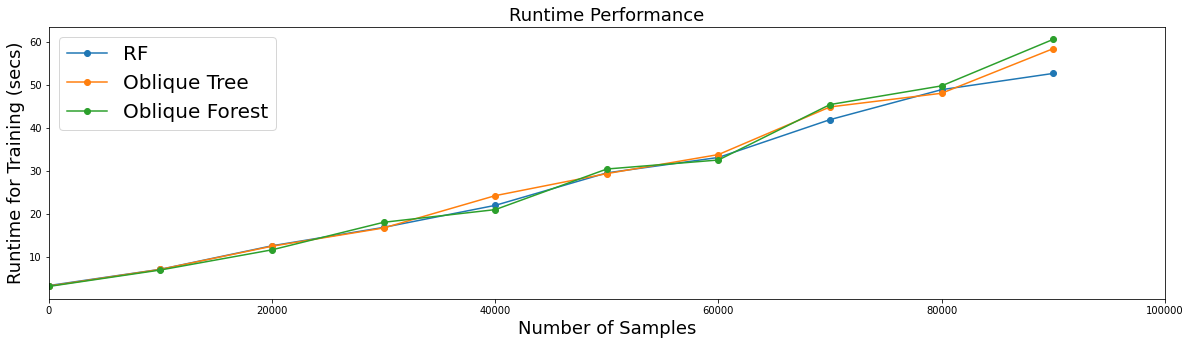

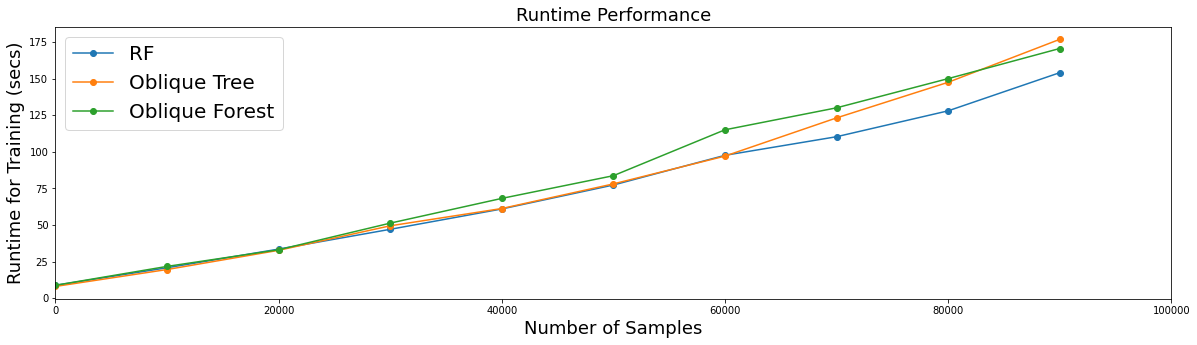

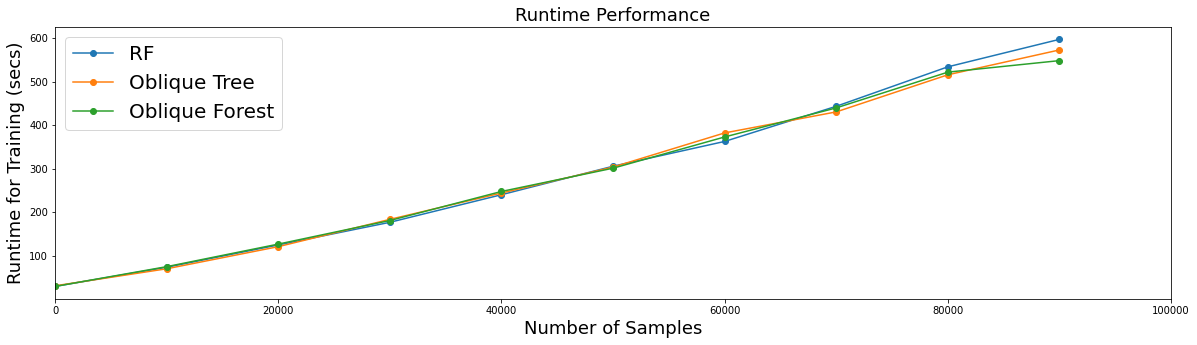

In [8]:
for i in dim:
    print(f"{'#' * 30}\nBenchmarking with {i} dimension\n{'#' * 30}")
    clf_otree, clf_oforest = init()
    rf_result = run_test(n=n, dim=i, filename=f'{saveDir}/{today}_tree_benchmark_RF_dev_dim={i}.pkl', train=train)
    otree_result = run_test(n=n, dim=i, clf=clf_otree, filename=f'{saveDir}/{today}_tree_benchmark_otree_dev_dim={i}.pkl', train=train)
    oforest_result = run_test(n=n, dim=i, clf=clf_oforest, filename=f'{saveDir}/{today}_tree_benchmark_oforest_dev_dim={i}.pkl', train=train)

    generate_fig(dim=i)